# Background 


### notes about the implementation 
-  both input and recurrent weight are combined into 1 kernel matrix 


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib.cm as cm
import numpy as np
import tensorflow as tf
import collections
import hashlib
import numbers
from datetime import datetime
from pathlib import Path
import os

import sys
sys.path.append('../')
import kernl_spiking_cell_v4 as kernl_spiking_cell
import adding_problem


In [2]:
tensor_learning_rate = 1e-6
weight_learning_rate = 1e-3
training_steps = 4000
buffer_size=700
batch_size = 50
training_size=batch_size*training_steps
epochs=1
test_size=10000
display_step = 200
grad_clip=100
# Network Parameters
# adding problem data input (first input are the random digits , second input is the mask)
time_steps = 100
num_hidden = 200 # hidden layer num of features
num_output = 1 # value of the addition estimation
#
num_input=2
num_units_input_layer=50
num_context_unit=1
# Noise Parameters
perturbation_std=1e-10
# save dir
# create a training and testing dataset
training_x, training_y = adding_problem.get_batch(batch_size=training_size,time_steps=time_steps)
testing_x, testing_y = adding_problem.get_batch(batch_size=test_size,time_steps=time_steps)


savepath='/home/eghbal/Desktop/snn_add_T_1e+02_eta_weight_1e-03_batch_5e+01_hum_hidd_2e+02_gc_1e+02_steps_4e+03_run_20190311_1628/'

In [7]:
def _hinton_identity_initializer(shape,dtype=None,partition_info=None,verify_shape=None, max_val=1):
    if dtype is None:
        dtype=tf.float32
    #extract second dimension
    W_rec=tf.eye(shape[-1],dtype=dtype)
    new_shape=[shape[0]-shape[-1],shape[-1]]
    W_in = tf.get_variable("W_in", shape=new_shape,
           initializer=tf.contrib.layers.xavier_initializer())
    #W_in=tf.random_normal(new_shape,mean=0,stddev=0.001)
    return tf.concat([W_in,W_rec],axis=0)


## define KeRNL unit
def kernl_snn_all_states(x,context):
    with tf.variable_scope('input_layer') as scope:
        input_layer_cell=kernl_spiking_cell.input_spike_cell(num_units=num_units_input_layer)
        output_l1, states_l1 = tf.nn.dynamic_rnn(input_layer_cell, dtype=tf.float32, inputs=x)
    with tf.variable_scope('hidden_layer') as scope:
        hidden_layer_cell=kernl_spiking_cell.kernl_spike_Cell(num_units=num_hidden,
                                                                 num_inputs=num_units_input_layer+num_context_unit,
                                                                 time_steps=time_steps,
                                                                 output_is_tuple=True,
                                                                 tau_refract=2.0,
                                                                 tau_m=20,
                                                                 noise_param=perturbation_std,
                                                                 sensitivity_initializer=tf.initializers.identity(),
                                                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        output_hidden, states_hidden = tf.nn.dynamic_rnn(hidden_layer_cell, dtype=tf.float32, inputs=tf.concat([output_l1,context],-1))
    with tf.variable_scope('output_layer') as scope :
        output_layer_cell=kernl_spiking_cell.output_spike_cell(num_units=num_output,kernel_initializer=tf.contrib.layers.xavier_initializer())
        output_voltage, voltage_states=tf.nn.dynamic_rnn(output_layer_cell,dtype=tf.float32,inputs=output_hidden.spike)
    return output_voltage,output_hidden, tf.concat([output_l1,context],-1)

tf.reset_default_graph()
graph=tf.Graph()
with graph.as_default():

    # define weights and inputs to the network
    BATCH_SIZE=tf.placeholder(tf.int64)
    X = tf.placeholder("float", [None, time_steps, num_input])
    Y = tf.placeholder("float", [None, num_output])
    # define a function for extraction of variable names
    dataset=tf.data.Dataset.from_tensor_slices((X,Y)).batch(BATCH_SIZE).repeat()
    dataset = dataset.shuffle(buffer_size=buffer_size)
    iter = dataset.make_initializable_iterator()
    inputs,labels =iter.get_next()
    #
    kernl_output,kernl_hidden_states,kernl_input_hidden=kernl_snn_all_states(tf.expand_dims(inputs[:,:,0],axis=-1),tf.expand_dims(inputs[:,:,1],axis=-1))
    trainables=tf.trainable_variables()
    variable_names=[v.name for v in tf.trainable_variables()]
    #
    find_joing_index = lambda x, name_1,name_2 : [a and b for a,b in zip([np.unicode_.find(k.name, name_1)>-1 for k in x] ,[np.unicode_.find(k.name, name_2)>-1 for k in x])].index(True)
    # find trainable parameters for kernl
    with tf.name_scope('kernl_Trainables') as scope:
        kernl_output_weight_index= find_joing_index(trainables,'output_layer','kernel')
        kernl_temporal_filter_index= find_joing_index(trainables,'kernl','temporal_filter')
        kernl_sensitivity_tensor_index= find_joing_index(trainables,'kernl','sensitivity_tensor')
        kernl_kernel_index= find_joing_index(trainables,'hidden_layer','kernel')
    #
        kernl_tensor_training_indices=np.asarray([kernl_sensitivity_tensor_index,kernl_temporal_filter_index],dtype=np.int)
        kernl_tensor_trainables= [trainables[k] for k in kernl_tensor_training_indices]
    #
        kernl_weight_training_indices=np.asarray([kernl_kernel_index,kernl_output_weight_index],dtype=np.int)
        kernl_weight_trainables= [trainables[k] for k in kernl_weight_training_indices]

    # define loss functions
    ##################
    # kernl train ####
    ##################
    with tf.name_scope('kernl_train_tensors') as scope:
        state_diff_int=tf.subtract(kernl_hidden_states.v_mem_hat[:,:,:], kernl_hidden_states.v_mem[:,:,:])
        estimate_state_diff_int=tf.einsum('unv,vk->unk',kernl_hidden_states.Theta,trainables[kernl_sensitivity_tensor_index])
        kernl_loss_state_prediction=tf.losses.mean_squared_error(state_diff_int,estimate_state_diff_int)
        kernl_tensor_optimizer = tf.train.RMSPropOptimizer(learning_rate=tensor_learning_rate)
        kernl_tensor_grads=tf.gradients(ys=kernl_loss_state_prediction,xs=kernl_tensor_trainables)
        kernl_tensor_grad_and_vars=list(zip(kernl_tensor_grads,kernl_tensor_trainables))
        kernl_tensor_train_op=kernl_tensor_optimizer.apply_gradients(kernl_tensor_grad_and_vars)

    with tf.name_scope('kernl_train_weights') as scope:
        kernl_weight_optimizer = tf.train.RMSPropOptimizer(learning_rate=weight_learning_rate)
        kernl_loss_output_prediction=tf.losses.mean_squared_error(labels,kernl_output[:,-1,:])
        kernl_grad_cost_to_output=tf.scalar_mul(2,tf.subtract(labels,kernl_output[:,-1,:]))
        kernl_error_in_hidden_state=tf.matmul(kernl_grad_cost_to_output,tf.transpose(trainables[kernl_output_weight_index]))
        kernl_delta_weight=tf.matmul(kernl_error_in_hidden_state,trainables[kernl_sensitivity_tensor_index])
        kernl_weight_update_test=tf.einsum("un,unv->unv",kernl_delta_weight,kernl_hidden_states.eligibility_trace[:,-1,:,:])
        kernl_weight_update=tf.transpose(tf.reduce_mean(kernl_weight_update_test,axis=0))
        kernl_grad_cost_to_output_layer=tf.gradients(ys=kernl_loss_output_prediction,xs=trainables[kernl_output_weight_index])
        kernl_weight_grads_and_vars=list(zip([kernl_weight_update,kernl_grad_cost_to_output_layer[0]],kernl_weight_trainables))
        kernl_cropped_weight_grads_and_vars=[(tf.clip_by_norm(grad, grad_clip),var) if  np.unicode_.find(var.name,'output')==-1 else (grad,var) for grad,var in kernl_weight_grads_and_vars]
        kernl_weight_train_op = kernl_weight_optimizer.apply_gradients(kernl_cropped_weight_grads_and_vars)

    with tf.name_scope("kernl_evaluate") as scope:
        kernl_loss_cross_validiation=tf.losses.mean_squared_error(labels,kernl_output[:,-1,:])

    with tf.name_scope('cross_validation_summary') as scope:
        tf.summary.scalar('cross_validation_summary',kernl_loss_cross_validiation+1e-10)
        kernl_evaluate_summary_op=tf.summary.merge_all(scope="cross_validation_summary")
    ##################
    # SUMMARIES ######
    ##################

    with tf.name_scope("kernl_tensor_summaries") as scope:
        tf.summary.histogram('kernl_sensitivity_tensor_grad',kernl_tensor_grads[0]+1e-10)
        tf.summary.histogram('kernl_sensitivity_tensor',trainables[kernl_sensitivity_tensor_index]+1e-10)
        tf.summary.histogram('kernl_temporal_filter_grad',kernl_tensor_grads[1]+1e-10)
        tf.summary.histogram('kernl_temporal_filter',trainables[kernl_temporal_filter_index]+1e-10)
        tf.summary.scalar('kernl_loss_state_prediction',kernl_loss_state_prediction+1e-10)
        kernl_tensor_merged_summary_op=tf.summary.merge_all(scope="kernl_tensor_summaries")

    with tf.name_scope("kernl_weight_summaries") as scope:
        
        tf.summary.histogram('kernl_kernel_grad',kernl_weight_update+1e-10)
        tf.summary.histogram('kernl_kernel',trainables[kernl_kernel_index]+1e-10)
        tf.summary.histogram('kernl_output_weights', trainables[kernl_output_weight_index]+1e-10)
        tf.summary.scalar('kernl_loss_output_prediction',kernl_loss_output_prediction+1e-10)
        kernl_weight_merged_summary_op=tf.summary.merge_all(scope="kernl_weight_summaries")

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
# verify initialization
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(graph=graph,) as sess : 
    sess.run(init)
    values,trainable_vars = sess.run([variable_names,trainables])
    for k, v in zip(variable_names,values):
        print(["variable: " , k])
        #print(["value: " , v])
        print(["variable: " , np.unicode_.find(k,'output')]) 
        print(["shape: " , v.shape])
        #print(v) training_steps


['variable: ', 'hidden_layer/rnn/kernl_spike__cell/temporal_filter:0']
['variable: ', -1]
['shape: ', (200,)]
['variable: ', 'hidden_layer/rnn/kernl_spike__cell/sensitivity_tensor:0']
['variable: ', -1]
['shape: ', (200, 200)]
['variable: ', 'hidden_layer/rnn/kernl_spike__cell/kernel:0']
['variable: ', -1]
['shape: ', (251, 200)]
['variable: ', 'output_layer/rnn/output_spike_cell/kernel:0']
['variable: ', 0]
['shape: ', (200, 1)]


In [8]:
with tf.Session(graph=graph) as sess: 
    
    saver.restore(sess, savepath+'model.ckpt')
    values,trainable_vars = sess.run([variable_names,trainables])
    sess.run(iter.initializer,feed_dict={X: training_x, Y: training_y , BATCH_SIZE: batch_size})
    batch_x,batch_y, outputs,hiddens,input_layer=sess.run([inputs,labels,kernl_output,kernl_hidden_states,kernl_input_hidden])

INFO:tensorflow:Restoring parameters from /home/eghbal/Desktop/snn_add_T_1e+02_eta_weight_1e-03_batch_5e+01_hum_hidd_2e+02_gc_1e+02_steps_4e+03_run_20190311_1628/model.ckpt


In [77]:
with tf.Session(graph=graph) as sess: 
    sess.run(init)
    values,trainable_vars = sess.run([variable_names,trainables])
    sess.run(iter.initializer,feed_dict={X: training_x, Y: training_y , BATCH_SIZE: batch_size})
    batch_x,batch_y, outputs,hiddens,input_layer=sess.run([inputs,labels,kernl_output,kernl_hidden_states,kernl_input_hidden])

Text(0, 0.5, 'output class')

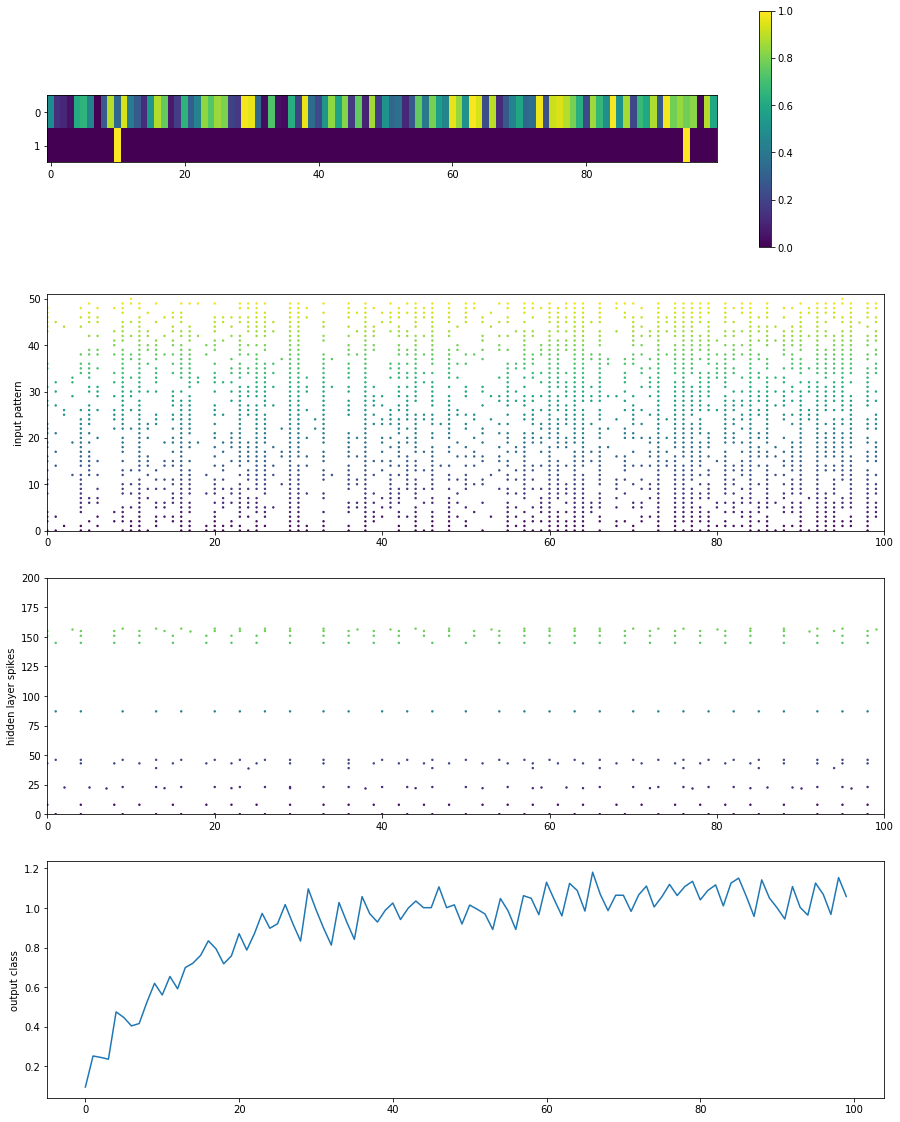

In [9]:
voltages=outputs[9,:,:]
hidden_spikes=hiddens.spike[9,:,:]
input_spikes=input_layer[9,:,:]
plt.figure(figsize=[15,20])


ax1=plt.subplot(411)
plt.imshow(np.transpose(batch_x[9]))
ax1.set_aspect(5)
plt.colorbar()
ax2=plt.subplot(412)
colors_map=cm.viridis(np.linspace(0,1,num_units_input_layer+num_context_unit))
for t in range(time_steps):
    cross=np.argwhere(input_spikes[t,:])
    ax2.scatter(cross*0+t,cross,color=colors_map[cross.flatten(),:],s=2)
    plt.xlim([0,time_steps])
    plt.ylim([0,num_units_input_layer+num_context_unit])

plt.ylabel('input pattern')
ax3=plt.subplot(413)
colors_map=cm.viridis(np.linspace(0,1,num_hidden))
for t in range(time_steps):
    cross=np.argwhere(hidden_spikes[t,:])
    ax3.scatter(cross*0+t,cross,color=colors_map[cross.flatten(),:],s=2)
    plt.xlim([0,time_steps])
    plt.ylim([0,num_hidden])
plt.ylabel('hidden layer spikes')
ax1=plt.subplot(414)
ax1.plot(voltages)

plt.ylabel('output class')

    

Text(0.5, 1.0, 'output weight')

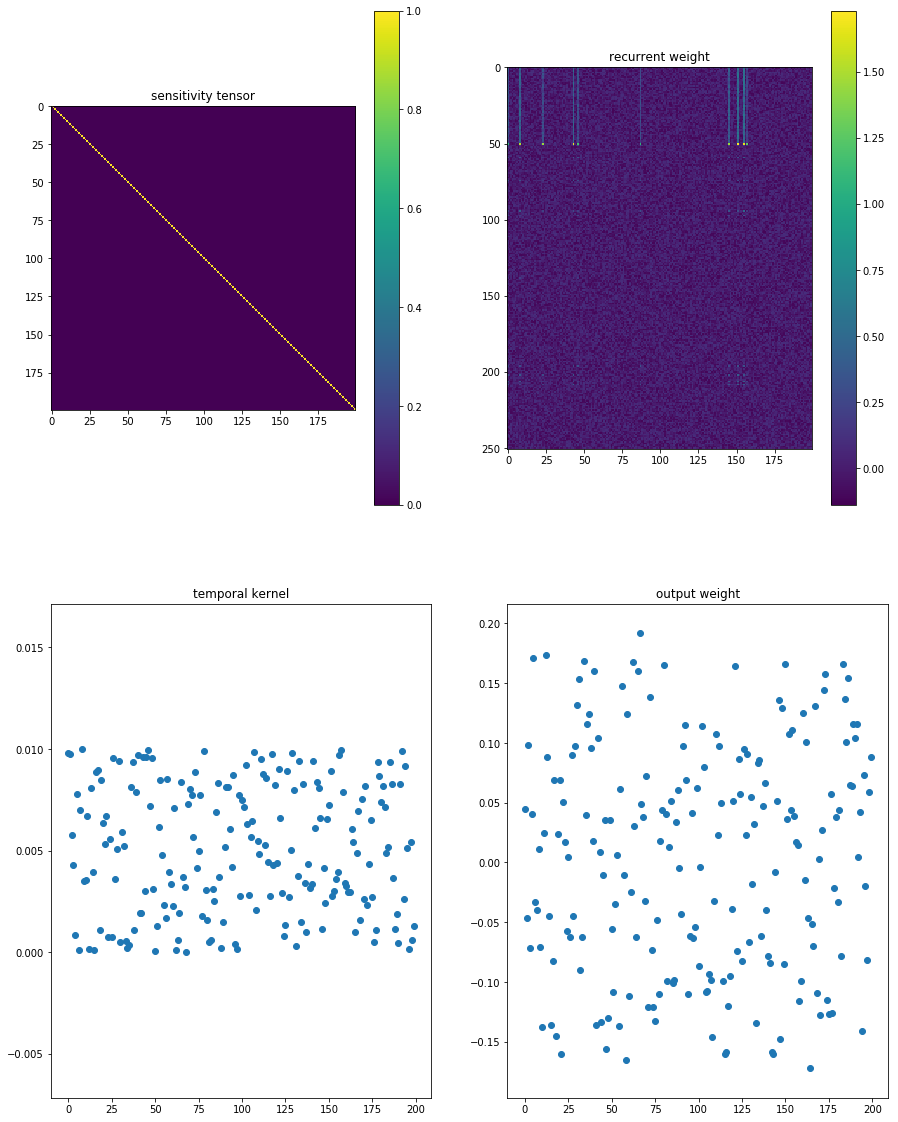

In [10]:
plt.figure(figsize=[15,20])
plt.subplot(221)
plt.imshow(values[1])
plt.colorbar()
plt.title('sensitivity tensor')
plt.subplot(222)
plt.imshow(values[2])
plt.colorbar()
plt.title('recurrent weight')
plt.subplot(223)
plt.scatter(range(values[0].shape[0]),values[0])
plt.title('temporal kernel')
plt.subplot(224)
plt.scatter(range(values[3].shape[0]),values[3])
plt.title('output weight')